# Hessian-free optimization with conjugate gradient method
Essentially we'd like to update $f(\mathbf{x}+\Delta \mathbf{x})$ by $\mathbf{x}_i = \mathbf{x}_{i-1} - \alpha_{i-1}\nabla f(\mathbf{x}_{i-1})$ with
$$
    \alpha_{i} = - \frac{[{\mathbf{x}_{i}}^T H(\mathbf{x}_{i}) + \nabla f(\mathbf{x}_{i})]\mathbf{d}_{i}}{{\mathbf{d}_{i}}^T H(\mathbf{x}_{i})\mathbf{d}_{i}}
$$
using the following approximation
$$
    f(\mathbf{x}+\Delta \mathbf{x}) \approx f(\mathbf{x}) + \nabla f(\mathbf{x})^T \Delta \mathbf{x} + \frac{1}{2} \Delta \mathbf{x}^T H(f) \Delta \mathbf{x}.
$$
where each row the Hessian can be approximated as a directional derivative in direction 
$$
    \mathbf{d}_{i} = -\nabla f(x_i) + \beta_{i-1} \mathbf{d}_{i-1} = - \nabla f(\mathbf{x}_{i-1}) + \frac{\nabla f(\mathbf{x}_{i})^T H(\mathbf{x}_{i-1}) \mathbf{d}_{i-1}}{{\mathbf{d}_{i-1}}^T H(\mathbf{x}_{i-1})\mathbf{d}_{i-1}}\mathbf{d}_{i-1}.
$$

The Hessian is quite horrid to compute, but its product with an arbitrary vector can be approximated as:
$$
    H\mathbf{v} \approx \frac{\nabla f(\mathbf{x}+\epsilon \mathbf{v}) - \nabla f(\mathbf{x})}{\epsilon}
$$
for sufficiently small $\epsilon > 0$. Essentially one can replace all terms with $H\mathbf{d}_i$ with the above approximation.

This short Jupyter notebook introduces how one may generalize the above method on a curved surface.

In [1]:
import sys, os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# file paths to call
IR2_file = np.loadtxt("./test_data/IR_2.txt")
aerinite_file = np.loadtxt("./test_data/aerinite_processed.txt", delimiter=",")

IR_x = IR2_file[:,0]
IR_y = IR2_file[:,1]

aerinite_x = aerinite_file[:,0]
aerinite_y = aerinite_file[:,1]

First define the Gaussians and its partial derivatives with respect to its parameters.

In [86]:
def gaussian(x, I, mu, sigma):
    diff = x - mu
    dist = diff**2
    exponential = np.exp(np.divide(-dist,2*sigma**2 + 1e-11))
    amplitude = np.divide(np.abs(I), np.sqrt(2*np.pi) * sigma + 1e-11)
    return amplitude * exponential

In [87]:
def gaussian_partial_I(x, I, mu, sigma):
    diff = x - mu
    dist = diff**2
    exponential = np.exp(np.divide(-dist,2*sigma**2 + 1e-11))
    amplitude = np.divide(np.sign(I), np.sqrt(2*np.pi) * sigma + 1e-11)
    return np.transpose(amplitude * exponential)

In [5]:
def gaussian_partial_mu(x, I, mu, sigma):
    diff = x - mu
    dist = diff**2
    exponential = np.exp(np.divide(-dist,2*sigma**2 + 1e-11))
    amplitude = I*(x-mu)/(np.sqrt(2*np.pi) * sigma**3)
    return np.transpose(amplitude * exponential)

In [88]:
def gaussian_partial_sigma(x, I, mu, sigma):
    diff = x - mu
    dist = diff**2
    exponential = np.exp(np.divide(-dist,2*sigma**2 + 1e-11))
    amplitude = np.divide(I*((x-mu)**2/sigma**2 - 1),np.sqrt(2*np.pi) * sigma**2 + 1e-11)
    return np.transpose(amplitude * exponential)

## Helper functions



In [7]:
def gaussian_gradient(x, I, mu, sigma, direction_vector=None):
    '''
        gaussian_gradient:
            INPUTS:
                x               : independent variable input (numpy array, size N)
                I               : scale factor
                mu              : centre of the gaussian
                sigma           : standard deviation of the gaussian
                direction_vector: (N, 3) matrix showing the direction to move to
        If the length of x is N, a gaussian is a mapping such that R^3XR^N -> R^N.
            OUTPUTS:
                numpy.ndarray of size (N,3)
    '''
    if direction_vector is None:
        partial_I = gaussian_partial_I(x, I, mu, sigma)
        partial_mu = gaussian_partial_mu(x, I, mu, sigma)
        partial_sigma = gaussian_partial_sigma(x, I, mu, sigma)
        return np.concatenate((partial_I[:,None], partial_mu[:,None], partial_sigma[:,None]), axis=1)
    else:
        I = np.ones_like(x) * I
        mu = np.ones_like(x) * mu
        sigma = np.ones_like(x) * sigma
        I_dir = direction_vector[:, 0]
        m_dir = direction_vector[:, 1]
        s_dir = direction_vector[:, 2]
        partial_I = gaussian_partial_I(x, I + I_dir, mu + m_dir, sigma + s_dir)
        partial_mu = gaussian_partial_mu(x, I + I_dir, mu + m_dir, sigma + s_dir)
        partial_sigma = gaussian_partial_sigma(x, I + I_dir, mu + m_dir, sigma + s_dir)
        return np.concatenate((partial_I[:,None], partial_mu[:,None], partial_sigma[:,None]), axis=1)

In [105]:
def hessian_product(x, I, mu, sigma, direction_vector, epsilon):
    '''
        computes the product between the Hessian and the direction vector of interest
        
        the direction vector must be a 3-tuple and the epsilon is some small positive number
    '''
    fx_ed = gaussian_gradient(x, I, mu, sigma, direction_vector=epsilon*direction_vector)
    fx    = gaussian_gradient(x, I, mu, sigma)
    return (fx_ed - fx) / epsilon

In [95]:
def pointwise_dotproduct (vector, hessian_times_direction):
    '''
        ((Nxm matrix), (Nxm matrix)) maps to N-vector
    '''
    length = vector.shape[0]
    out_arr = np.zeros(length)
    for i in range(length):
        k = np.dot(vector[i,:], hessian_times_direction[i,:])
        out_arr[i] = k
    return out_arr

In [112]:
def get_alpha(params, grad_in, hess_in, dir_vec):
    ''' 
        A function to produce the alphas
        INPUTS:
            x_vals  : x-values of the 
            params  : an 1D numpy array of length 3 (num_params)
            grad_in : gradient of the function of interest (Nx3 numpy array)
            hess_in : output of hessian_product (Nx3 numpy array)
            dir_vec : direction vector (Nx3 numpy array, input of hessian_product
        OUTPUT:
            a numpy array
    '''
    term1 = np.dot(hess_in, params)
    term2 = pointwise_dotproduct(dir_vec, grad_in)
    numerator = -1 * (term1 + term2)
    denominator = pointwise_dotproduct(dir_vec, hess_in) + 1e-11
    return np.divide(numerator, denominator)

In [125]:
def get_beta(grad_in, hess_in, dir_vec):
    numerator = pointwise_dotproduct(grad_in, hess_in)
    denominator = pointwise_dotproduct(dir_vec, hess_in)
    return np.divide(numerator, denominator)

## Main algorithm

The algorithm essentially requires one to follow the following steps:
0. Set the number of peaks of interest
1. Initialize the parameters (I'll just let them be ones at first and see how it goes)
2. Find the gradient
3. Find the direction vector
    - For the first run, set beta = 0
    - From the second run, compute the beta values with get_beta function above
4. Find the alpha using the get_alpha function above
5. Update the parameter-candidates 
6. Examine the error, terminate if the error's below its threshold, repeat 2 - 5 otherwise

In [61]:
start_params = np.abs(np.random.randn(3))

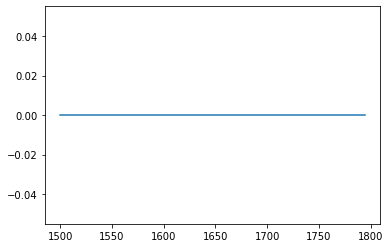

In [62]:
plt.plot(IR_x, gaussian(IR_x, start_params[0], start_params[1], start_params[2]))

In [63]:
def multiple_gaussians(x, params):
    ''' 
        sum of multiple Gaussians
        params must be an array of length 3n
    '''
    output_result = np.zeros_like(x)
    for i in range(0, len(params), 3):
        output_result += gaussian(x, params[i], params[i+1], params[i+2])
    return output_result

In [124]:
start_vals = np.random.randn(30)
result_tmp = multiple_gaussians(IR_x, start_vals)
gradient_tmp = []
for i in range(0,len(start_vals), 3):
    gradient_tmp.append(gaussian_gradient(IR_x, start_vals[0], start_vals[1],start_vals[2]))

In [120]:
def conjugate_gradient(x, y, start_params):
    switch = True
    attempts = []
    alphas = []
    betas = []
    derivs = []
    for i in range(0, len(start_params), 3):
        attempts.append(start_params[i:i+3])
    loop_num = 0
    while switch:
        updated_attempts = []
        for attempt in attempts:
            grad_vec = gaussian_gradient(x, *attempt)
            if loop_num == 0:
                dir_vec = grad_vec
            hess_vec = hessian_product(x, *attempt, grad_vec, epsilon=1e-5)
            alpha = get_alpha(attempt, grad_vec, hess_vec, dir_vec)

            # new parameters
            attempt = attempt + np.dot(alpha, dir_vec)
            updated_attempts.append(attempt)

            # update the direction
            beta = get_beta(x, grad_vec, hess_vec, dir_vec)
            dir_vec = -grad_vec + np.multiply(beta[:,None], dir_vec)

        





vec1 = [600, 1600, 200]
vec2 = [700, 1800, 300]
tmp2 = gaussian_gradient(IR_x, *vec1)
tmp = gaussian_gradient(IR_x, *vec2, tmp2)
hess_tmp = hessian_product(IR_x, *vec2, tmp2, epsilon=0.0001)
alpha_tmp = get_alpha(np.asarray([vec2[0], vec2[1],vec2[2]]), tmp2, hess_tmp, tmp2)
print(tmp.shape)
print(hess_tmp.shape)
print(alpha_tmp.shape)

print(np.mean(tmp))
print(np.mean(hess_tmp))
print(np.mean(alpha_tmp))

vec1 + np.dot(tmp2.transpose(), alpha_tmp)

(146, 3)
(146, 3)
(146,)
-0.0006549391667814955
-2.362793857097095e-08
856426.7561038946


array([ 262873.27190449, -157406.90976837, -847693.66363677])

In [137]:
a = get_beta(tmp2, hess_tmp, tmp2)
print(tmp2.shape)
print(a.shape)
k = np.multiply(beta[:,None], tmp2)
print(k.shape)

(146, 3)
(146,)
(146, 3)


In [140]:
alpha_tmp.shape
tmp.shape

np.dot(alpha_tmp, tmp)

array([ 120258.81448453, -251087.2000479 ,  -94808.34091806])